# Graph ConvNet

In [1]:
LOAD_CHECKPOINT = True
TENSORBOARD = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx

from model import GraphNet
from pathlib import Path
from torch.utils.data import DataLoader
from utils.common import get_device
from utils.config import load_config
from utils.model import save_checkpoint, load_checkpoint
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.tensorboard import SummaryWriter

## Model Inputs

| Variable | Meaning | Dimensions |
| -------- | ------- | ---------- |
| batch_edges | Adj matrix special connections* | B x num_nodes x num_nodes
| batch_edges_values | Distance Matrix | B x num_nodes x num_nodes
| batch_edges_target | Target adj matrix | B x num_nodes x num_nodes
| batch_nodes | Ones vector | B x num_nodes
| batch_nodes_coord | Coordinates | B x num_nodes x 2
| *batch_nodes_target* | Value represents ordering in tour | B x num_nodes


*special connections:
* 1 - k-nearest neighbour
* 2 - self connections
* 0 - otherwise

In [3]:
!ls data/

preds.pkl             vrp_20_demand_norm.pt
vrp_20.pt             vrp_20_nodes.pkl


In [4]:
dataset = torch.load("data/vrp_20_demand_norm.pt")

train_dataloader = DataLoader(dataset.train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset.test, batch_size=64, shuffle=True)

len(train_dataloader), len(test_dataloader)

(297, 16)

In [5]:
def first(tensor): return tensor[0]
def get_batch(dl): return next(iter(dl))

## Visualise an instance

TODO: Shouldn't be required at this point

In [ ]:
batch_features, batch_targets = get_batch(train_dataloader)
coords = first(batch_features[0]).cpu().numpy()
target = first(batch_targets).cpu().numpy()

In [ ]:
fig, ax = plt.subplots()

ax.scatter(coords[:, 0], coords[:, 1])

for i, row in enumerate(target):
    args = np.argwhere(row>0).flatten()
    x_i = coords[i]
    
    for x_j in coords[args]:
        ax.plot([x_i[0], x_j[0]], [x_i[1], x_j[1]], c='tab:blue')

plt.show()

In [ ]:
fig, ax = plt.subplots()

G = nx.from_numpy_array(target)
pos = dict(enumerate(coords))

nx.draw_networkx(G, pos, ax=ax)

plt.show()

## Compute class weights

Due to the class imbalance, we need to calculate the class weights.

In [6]:
targets = np.array([target_edges.cpu().numpy() for _, target_edges in dataset.train])

In [7]:
class_labels = targets.flatten()

edge_class_weights = compute_class_weight('balanced',
                                          classes=np.unique(class_labels),
                                          y=class_labels)
edge_class_weights = torch.tensor(edge_class_weights, dtype=torch.float)

edge_class_weights

tensor([0.5619, 4.5419])

## The Model

In [8]:
device = get_device()
print("Device", device)

Device cpu


In [9]:
config = load_config(num_gcn_layers=5, hidden_dim=16, node_features=3)
config.dropout = None

In [10]:
LEARNING_RATE = 0.001

model = GraphNet(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(edge_class_weights)

In [ ]:
# tensorboard
# writer = SummaryWriter()

In [ ]:
if LOAD_CHECKPOINT:
    print("Loading from checkpoint")
    checkpoint = load_checkpoint("model_20_dropout.pt")

    config = checkpoint['config']
    edge_class_weights = checkpoint['class_weights']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## Test Forward Pass

In [12]:
dataset.train[0][0].keys()

dict_keys(['node_features', 'dist_matrix', 'edge_feat_matrix'])

In [14]:
batch_features, batch_target = get_batch(train_dataloader)

y_pred = model.forward(batch_features["node_features"],
                       batch_features["dist_matrix"], 
                       batch_features["edge_feat_matrix"])

y_pred.shape

torch.Size([64, 20, 20, 2])

## Define metrics

In [15]:
from sklearn.metrics import accuracy_score, \
balanced_accuracy_score, precision_recall_fscore_support, precision_recall_curve

def get_metrics(targets, predictions):
    # Batch accuracy
    acc = accuracy_score(targets.flatten(), predictions.flatten())

    # Balanced accuracy
    bal_acc = balanced_accuracy_score(targets.flatten(), predictions.flatten(), adjusted=True)

    # Precision and Recall
    precision, recall, f1_score, _ = precision_recall_fscore_support(targets.flatten(),
                                                                     predictions.flatten(),
                                                                     average='binary')
    return acc, bal_acc, precision, recall, f1_score

## Validation loop

In [16]:
def eval_model(batch_node_features, batch_dist_matrix, batch_edge_features):
    model.eval()

    with torch.no_grad():
        preds = model(batch_node_features, batch_dist_matrix, batch_edge_features)

    return preds


def validate(dl):
    targets = []
    predictions = []
    
    for batch_features, batch_targets in dl:
        batch_node_features = batch_features["node_features"].to(device)
        batch_dist_matrix = batch_features["dist_matrix"].to(device)
        batch_edge_features = batch_features["edge_feat_matrix"].to(device)

        batch_targets = batch_targets.cpu().numpy()
    
        y_preds = eval_model(batch_node_features, batch_dist_matrix, batch_edge_features)
        y_preds = F.softmax(y_preds, dim=3)
        y_preds = y_preds.argmax(dim=3)
        y_preds = y_preds.cpu().numpy()
        
        targets.append(batch_targets)
        predictions.append(y_preds)
        
    targets = np.concatenate(targets)
    predictions = np.concatenate(predictions)
        
    return targets, predictions

## Training Loop

In [18]:
def get_loss(preds, targets):
    preds_perm = preds.permute(0, 3, 1, 2)
    
    return criterion(preds_perm, targets)

def train_one_epoch(batch_node_features, batch_dist_matrix, batch_edge_features, batch_targets):
    model.train()
    optimizer.zero_grad()
    
    preds = model(batch_node_features, batch_dist_matrix, batch_edge_features)
    loss = get_loss(preds, batch_targets)
    loss.backward()
    
    optimizer.step()

    return loss

def train(num_epochs, dataloader):
    epoch_losses = []
    epoch_metrics = []
    
    for epoch in range(num_epochs):
        running_loss = 0
    
        for minibatch_idx, (batch_features, batch_targets) in enumerate(dataloader):
            batch_node_features = batch_features["node_features"].to(device)
            batch_dist_matrix = batch_features["dist_matrix"].to(device)
            batch_edge_features = batch_features["edge_feat_matrix"].to(device)
            batch_targets = batch_targets.to(device)
            
            loss = train_one_epoch(batch_node_features,
                                   batch_dist_matrix,
                                   batch_edge_features,
                                   batch_targets)
            
            running_loss += loss.item()

        # Losses
        epoch_loss = running_loss / len(dataloader)
        epoch_losses.append(epoch_loss)
        writer.add_scalar("Loss/train", epoch_loss, epoch)

        print(f'Epoch: {epoch:02d}, Loss: {epoch_loss:.4f}')
        
        # Metrics on test dataset
        targets, predictions = validate(test_dataloader)
        metrics = get_metrics(targets, predictions)
        
        acc, bal_acc, precision, recall, f1_score = metrics
        epoch_metrics.append(metrics)
        writer.add_scalar("Metrics/accuracy", acc, epoch)
        writer.add_scalar("Metrics/bal. accuracy", bal_acc, epoch)
        writer.add_scalar("Metrics/precision", precision, epoch)
        writer.add_scalar("Metrics/recall", recall, epoch)
        writer.add_scalar("Metrics/f1 score", f1_score, epoch)

In [19]:
print("Current config:", config, end='\n\n')

Current config: {'hidden_dim': 16, 'node_features': 3, 'edge_weight_features': 1, 'edge_values_features': 3, 'num_gcn_layers': 5, 'num_mlp_layers': 3}



In [ ]:
train(20, train_dataloader)

writer.flush()

Training with config: {'hidden_dim': 16, 'node_features': 3, 'edge_weight_features': 1, 'edge_values_features': 3, 'num_gcn_layers': 5, 'num_mlp_layers': 3, 'enable_dropout': True}

Epoch: 00, Loss: 0.3878
Epoch: 01, Loss: 0.3119
Epoch: 02, Loss: 0.2910
Epoch: 03, Loss: 0.2812
Epoch: 04, Loss: 0.2757
Epoch: 05, Loss: 0.2716
Epoch: 06, Loss: 0.2675
Epoch: 07, Loss: 0.2631
Epoch: 08, Loss: 0.2598
Epoch: 09, Loss: 0.2576


In [27]:
writer.close()

## Final metrics

In [20]:
targets, predictions = validate(test_dataloader)
acc, bal_acc, precision, recall, f1_score = get_metrics(targets, predictions)

print("Accuracy:", acc)
print("Balanced Accuracy:", bal_acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score", f1_score)

Accuracy: 0.88805
Balanced Accuracy: 0.7989205109900475
Precision: 0.4955703211517165
Recall: 0.9140944167044939
F1 score 0.6427032633846645


## Plot the results

In [65]:
test_features, test_targets = get_batch(test_dataloader)
coords = test_features[0]

In [66]:
pred = eval_model(*test_features)
pred = F.softmax(pred, dim=3)
pred_prob = pred[..., 1].cpu().numpy()
pred_prob_argmax = pred.argmax(dim=3).cpu().numpy()

In [71]:
from utils.data import store_pickle

obj = test_features, test_targets, pred

store_pickle(obj, 'preds.pkl')

In [51]:
def adj_matrix_to_list(adj_matrix):
    adj_list = []
    
    for i, row in enumerate(adj_matrix):
        dest = np.argwhere(row>0).flatten()
        src = np.full(dest.size, i)
        
        adj_list.extend(zip(src, dest))
    
    return adj_list

def plot_edge_predictions(coords, pred, target, ax):
    G = nx.from_numpy_array(target)
    pos = dict(enumerate(coords))
    
    pred_edge_list = adj_matrix_to_list(pred)

    nx.draw_networkx(G, pos, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=pred_edge_list, edge_color='red', alpha=0.1, width=3, ax=ax)
    
def get_over_threshold(preds, threshold):
    pred = np.copy(preds)
    pred[preds >= threshold] = 1
    pred[preds < threshold] = 0
    
    return pred

In [56]:
p = get_over_threshold(pred_prob, 0.75)

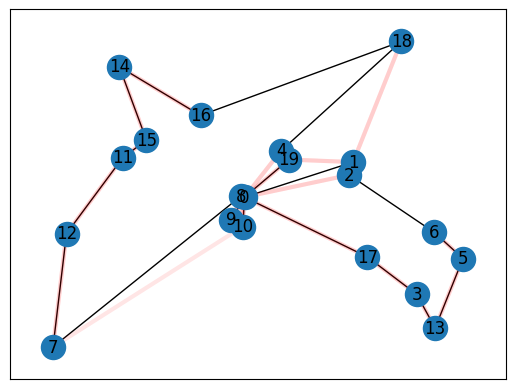

In [57]:
fig, ax = plt.subplots()
i = 0
plot_edge_predictions(coords[i].cpu().numpy(), p[i], test_targets[i].cpu().numpy(), ax=ax)

In [60]:
from utils.beam_search import Beamsearch

bs = Beamsearch(beam_width=100, trans_probs=torch.tensor(pred_prob), num_vehicles=1)
bs.search()

In [61]:
bs.sanity_check()

In [62]:
beams = bs.get_beam(0)

In [63]:
beams[0]

tensor([ 0,  4, 19,  2,  1, 18, 14, 16, 15, 11, 12,  7, 10,  9,  8, 17,  3, 13,
         5,  6])

In [64]:
bs.get_beam(99)[0]

tensor([ 0, 10,  9,  7, 12, 11, 15, 14, 18,  1,  2, 19,  4,  8, 17,  3,  5,  6,
        13, 16])

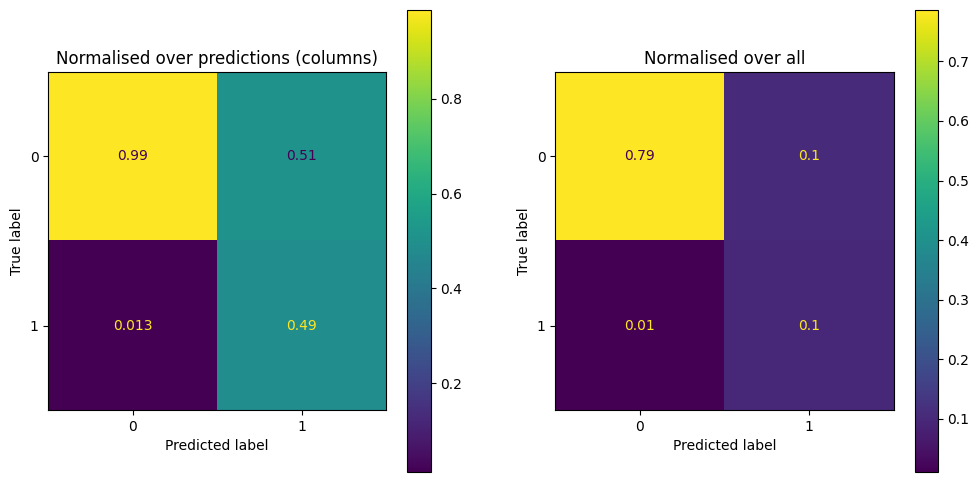

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay.from_predictions(targets.flatten(), preds.flatten(), normalize='pred', ax=axes[0])
ConfusionMatrixDisplay.from_predictions(targets.flatten(), preds.flatten(), normalize='all', ax=axes[1])
axes[0].set_title("Normalised over predictions (columns)")
axes[1].set_title("Normalised over all")

plt.show()

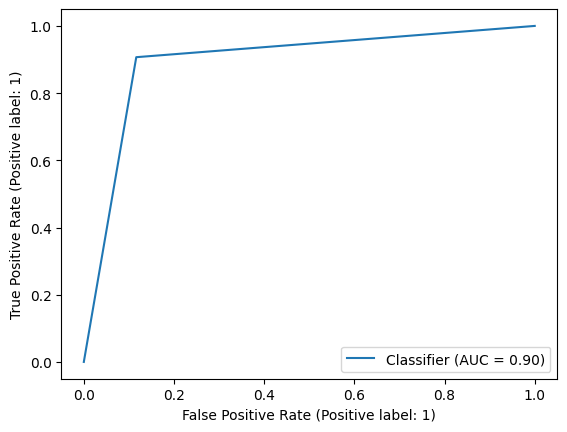

In [105]:
RocCurveDisplay.from_predictions(targets.flatten(), preds.flatten())

plt.show()